In [128]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

In [129]:
# Read train and validation data
train = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_t_var_sel.csv")
val = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_v_var_sel.csv")

In [130]:
# First ten observations of train
train.head(10)

# We have a dataset derived from previous analysis, which allowed us to indentify 
# potential predictor variables related to the purchase of the annuity product

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,CCPURC,SDB,INCOME,LORES,HMVAL,AGE,CRSCORE,INAREA,INS,BRANCH
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1.0,0,4.0,7.0,87.0,51.0,674.0,1,0,B2
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,0.0,0,30.0,8.5,97.0,60.0,640.0,1,1,B3
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,0.0,0,19.0,3.0,107.0,55.0,662.0,1,1,B7
3,0.8,1,190.03,3,880.25,1,0,1,5.65,NaN,...,NaN,1,20.0,4.0,107.0,40.0,642.0,1,0,B14
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,NaN,...,NaN,0,24.0,8.5,95.0,54.0,732.0,1,0,B15
5,5.3,0,0.00,0,0.00,0,0,0,0.00,NaN,...,NaN,0,8.0,12.5,76.0,61.0,688.0,1,1,B19
6,9.0,1,1072.55,1,590.25,0,0,1,5.78,NaN,...,NaN,0,45.0,8.5,111.0,54.0,635.0,1,1,B15
7,4.0,0,0.00,0,0.00,0,0,0,0.00,NaN,...,NaN,0,35.0,3.5,99.0,46.0,642.0,1,1,B14
8,NaN,1,998.25,2,1471.81,4,1,0,0.00,0.0,...,0.0,0,88.0,8.0,129.0,22.0,626.0,1,1,B1
9,1.5,0,0.00,0,0.00,0,0,0,0.00,NaN,...,NaN,0,31.0,4.0,97.0,53.0,693.0,0,0,B18


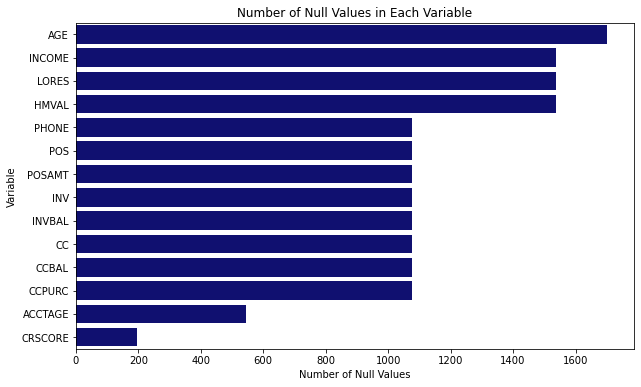

,Variable,Null_Count
12,AGE,1702
9,INCOME,1537
10,LORES,1537
11,HMVAL,1537
1,PHONE,1075
2,POS,1075
3,POSAMT,1075
4,INV,1075
5,INVBAL,1075
6,CC,1075


In [131]:
#Find null values
var_with_null = {'Variable': [], 'Null_Count': []}

# Check all variables
for column in train.columns:
    null_count = train[column].isnull().sum()
    if null_count > 0:
        var_with_null['Variable'].append(column)
        var_with_null['Null_Count'].append(null_count)

var_with_null = pd.DataFrame(var_with_null).sort_values(by = 'Null_Count', ascending = False)

# Plot of the number of null values
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Null_Count', y = 'Variable', data = var_with_null, color = 'navy')
plt.title('Number of Null Values in Each Variable')
plt.xlabel('Number of Null Values')
plt.ylabel('Variable')
plt.show()

var_with_null

In [132]:
# Create a binary flag variable that indicates missing values
for var in var_with_null['Variable']:
    train[f'{var}_FLAG'] = train[var].notna().astype(int)

train

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,PHONE_FLAG,POS_FLAG,POSAMT_FLAG,INV_FLAG,INVBAL_FLAG,CC_FLAG,CCBAL_FLAG,CCPURC_FLAG,ACCTAGE_FLAG,CRSCORE_FLAG
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,1,1,1,1,1,1,1,1,1,1
3,0.8,1,190.03,3,880.25,1,0,1,5.65,NaN,...,0,0,0,0,0,0,0,0,1,1
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,NaN,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,10.8,1,2262.87,2,4761.00,7,0,1,7.75,2.0,...,1,1,1,1,1,1,1,1,1,1
8491,6.5,1,3683.22,2,3271.05,13,1,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
8492,8.6,1,46593.63,3,55203.58,9,1,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
8493,NaN,0,0.00,0,0.00,0,0,0,0.00,0.0,...,1,1,1,1,1,1,1,1,0,1


In [133]:
# Identify classes of variables: categorical or continuous
cat_var = []
cont_var = []

for column in train.columns:
    if column == 'BRANCH':
        cat_var.append(column)
    elif train[column].nunique() <= 10:
        cat_var.append(column)
    else:
        cont_var.append(column)

In [134]:
# Use median and mode imputation for continuous and categorical variables, respectively
for var in var_with_null['Variable']:
    if var in cat_var:
        train[var] = train[var].fillna(train[var].mode()[0])
    else:
        train[var] = train[var].fillna(train[var].median())

In [135]:
# Divide predictor variables and target variable into individual dataframes
X_train = train.drop(['INS'], axis = 1)
Y_train = train['INS']

# Create dummy variables for branch (branch is a categorical variable with string values)
branch_dummy = pd.get_dummies((train['BRANCH']), drop_first=True)

# Replace branch with the dummy variables created
X_train = X_train.drop(['BRANCH'], axis = 1)
X_train = pd.concat([X_train, branch_dummy], axis = 1)

## Validation Dataset
* Apply all changes made to the training dataset onto the validation dataset

In [209]:
# Create a binary flag variable that indicates missing values
for var in var_with_null['Variable']:
    val[f'{var}_FLAG'] = val[var].notna().astype(int)

# Use median and mode imputation for continuous and categorical variables, respectively
for var in var_with_null['Variable']:
    if var in cat_var:
        val[var] = val[var].fillna(train[var].mode()[0])
    else:
        val[var] = val[var].fillna(train[var].median())

# Divide predictor variables and target variable into individual dataframes
X_val = val.drop(['INS'], axis = 1)
Y_val = val['INS']

# Create dummy variables for branch (branch is a categorical variable with string values)
branch_dummy = pd.get_dummies((val['BRANCH']), drop_first=True)

# Replace branch with the dummy variables created
X_val = X_val.drop(['BRANCH'], axis = 1)
X_val = pd.concat([X_val, branch_dummy], axis = 1)

# XGBoost (Extreme gradient boosting)

* **Feature Importance**: measures the average decrease in purity in the nodes of the tree (essentially measuring how much each variable improves the purity of the model when it is added)
* **Hyperparameters examples**:

    * Learning Rate (**eta**): Learning rate controls the step size during the optimization process. Lower values typically lead to slower training but can result in better generalization.

    * Maximum Depth (**max_depth**): Maximum depth of each tree in the ensemble. Deeper trees can capture more complex patterns but are more prone to overfitting.

    * Number of Trees (**n_estimators**): Number of boosting rounds or trees to build. Increasing the number of trees can improve model performance, but there's a trade-off with computational cost.

    * Subsample Ratio (**subsample**): Subsample ratio of the training instances. It controls the proportion of samples used for training each tree. Lower values can reduce overfitting.

    * Column Subsampling (**colsample_bytree** or **colsample_bylevel**): Fraction of features (columns) to randomly sample at each tree node. It can help prevent overfitting by introducing randomness into the feature selection process.

    * Regularization Parameters (**reg_alpha** and **reg_lambda**): L1 (Lasso) and L2 (Ridge) regularization terms applied to the weights of the tree nodes. They penalize large parameter values and help prevent overfitting.

    * Minimum Child Weight (**min_child_weight**): Minimum sum of instance weight (hessian) needed in a child node. It can be used to control the partitioning process and prevent overfitting.

    * Minimum Split Loss (**gamma**): Minimum loss reduction required to make a further partition on a leaf node of the tree. It acts as a regularization parameter by controlling the complexity of the trees.

    * Learning Task Parameters: Depending on the learning task (classification or regression), specific parameters might be tuned. For example, **objective** specifies the learning task and **eval_metric** determines the evaluation metric used during training.

    * Early Stopping (**early_stopping_rounds**): A technique to prevent overfitting by stopping training when the performance on a validation set stops improving.

    * **scale_pos_weight**: addresses class imbalance in binary classification problems by assigning different weights to the positive class samples (usually the minority class) and the negative class samples (usually the majority class). By default, it's set to 1, meaning that both classes are treated equally.

## Training Dataset

In [210]:
# Build a XGBoost classification model
xgb = XGBClassifier(n_estimators = 50, subsample = 0.5, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', early_stopping_rounds = 10)

xgb.fit(X_train, Y_train, verbose = True, eval_set = [(X_val, Y_val)])  # Training on the training dataset, but evaluates how many tree to build on the validation dataset

# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

# [10]	validation_0-auc:0.79178

[0]	validation_0-auc:0.74531
[1]	validation_0-auc:0.76084
[2]	validation_0-auc:0.77323
[3]	validation_0-auc:0.77764
[4]	validation_0-auc:0.77833
[5]	validation_0-auc:0.78001
[6]	validation_0-auc:0.78387
[7]	validation_0-auc:0.78685
[8]	validation_0-auc:0.78759
[9]	validation_0-auc:0.78983
[10]	validation_0-auc:0.79178
[11]	validation_0-auc:0.78926
[12]	validation_0-auc:0.78869
[13]	validation_0-auc:0.78584
[14]	validation_0-auc:0.78626
[15]	validation_0-auc:0.78544
[16]	validation_0-auc:0.78432
[17]	validation_0-auc:0.78198
[18]	validation_0-auc:0.78176
[19]	validation_0-auc:0.78254
[20]	validation_0-auc:0.77996


,Feature,Importance
23,MM,0.136565
1,DDA,0.109333
12,SAVBAL,0.055622
19,IRA,0.031343
21,INV,0.028542
...,...,...
44,INVBAL_FLAG,0.000000
43,INV_FLAG,0.000000
42,POSAMT_FLAG,0.000000
41,POS_FLAG,0.000000


In [211]:
# First round of tuning hyperparameters
param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'eta': [0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5, 7, 9, 11],
    'subsample': [0.25, 0.5, 0.75, 1],
    'gamma': [0, 0.25, 1],
    'reg_lambda': [0, 1, 5]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10)

grid_search.fit(X_train, Y_train)

grid_search.best_params_

{'eta': 0.3,
 'gamma': 0.25,
 'max_depth': 5,
 'n_estimators': 15,
 'reg_lambda': 1,
 'subsample': 1}

In [212]:
# After first round of tuning
xgb = XGBClassifier(n_estimators = 20, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    max_depth = 5, eta = 0.3, reg_lambda = 1, gamma = 0.25, early_stopping_rounds = 10)

xgb.fit(X_train, Y_train, verbose = True, eval_set = [(X_val, Y_val)])

# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

[0]	validation_0-auc:0.74355
[1]	validation_0-auc:0.75786
[2]	validation_0-auc:0.77480
[3]	validation_0-auc:0.78412
[4]	validation_0-auc:0.78532
[5]	validation_0-auc:0.78960
[6]	validation_0-auc:0.78896
[7]	validation_0-auc:0.78847
[8]	validation_0-auc:0.78919
[9]	validation_0-auc:0.79233
[10]	validation_0-auc:0.79193
[11]	validation_0-auc:0.79339
[12]	validation_0-auc:0.79347
[13]	validation_0-auc:0.79485
[14]	validation_0-auc:0.79575
[15]	validation_0-auc:0.79554
[16]	validation_0-auc:0.79527
[17]	validation_0-auc:0.79449
[18]	validation_0-auc:0.79423
[19]	validation_0-auc:0.79471


,Feature,Importance
23,MM,0.262825
1,DDA,0.086918
12,SAVBAL,0.075734
2,DDABAL,0.034207
24,MMBAL,0.032485
...,...,...
47,CCPURC_FLAG,0.000000
46,CCBAL_FLAG,0.000000
45,CC_FLAG,0.000000
44,INVBAL_FLAG,0.000000


In [214]:
# Variable selection by comparing to a random variable
X_train_r = X_train.copy()
X_train_r['random'] = np.random.normal(0, 1, len(X_train))

X_val_r = X_val.copy()
X_val_r['random'] = np.random.normal(0, 1, len(X_val))

# Fit the model with the predictor dataset that includes the random variable
xgb = XGBClassifier(n_estimators = 20, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    max_depth = 5, eta = 0.3, reg_lambda = 1, gamma = 0.25, early_stopping_rounds = 10)

xgb.fit(X_train_r, Y_train, verbose = True, eval_set = [(X_val_r, Y_val)])

# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train_r.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

[0]	validation_0-auc:0.74355
[1]	validation_0-auc:0.75786
[2]	validation_0-auc:0.77510
[3]	validation_0-auc:0.78378
[4]	validation_0-auc:0.78509
[5]	validation_0-auc:0.78851
[6]	validation_0-auc:0.78901
[7]	validation_0-auc:0.79115
[8]	validation_0-auc:0.79196
[9]	validation_0-auc:0.79193
[10]	validation_0-auc:0.79220
[11]	validation_0-auc:0.79288
[12]	validation_0-auc:0.79320
[13]	validation_0-auc:0.79279
[14]	validation_0-auc:0.79366
[15]	validation_0-auc:0.79359
[16]	validation_0-auc:0.79353
[17]	validation_0-auc:0.79351
[18]	validation_0-auc:0.79304
[19]	validation_0-auc:0.79334


,Feature,Importance
23,MM,0.248634
1,DDA,0.100151
12,SAVBAL,0.076296
24,MMBAL,0.035310
18,CDBAL,0.033473
...,...,...
46,CCBAL_FLAG,0.000000
51,B11,0.000000
37,INCOME_FLAG,0.000000
49,CRSCORE_FLAG,0.000000


In [215]:
# Exclude all features determined to be less important compared to the random variable
feature_importance_df.reset_index(drop = True, inplace = True)
random_index = feature_importance_df.index[feature_importance_df['Feature'] == 'random'][0]

features_to_keep = feature_importance_df[:random_index]
features_to_keep = [col for col in features_to_keep['Feature']]
X_train_imp = X_train[features_to_keep]
X_train_imp

,MM,DDA,SAVBAL,MMBAL,CDBAL,IRA,DDABAL,PHONE_FLAG,CC,INV,...,CCBAL,DEPAMT,POS,B9,CD,LORES,MMCRED,HMVAL,INCOME,B10
0,0,1,0.00,0.00,0,0,1986.81,1,1.0,0.0,...,0.00,446.93,0.0,0,0,7.0,0,87.0,4.0,0
1,0,0,0.00,0.00,0,0,0.00,1,1.0,0.0,...,0.00,0.00,0.0,0,0,8.5,0,97.0,30.0,0
2,0,1,0.00,0.00,0,0,1069.78,1,1.0,0.0,...,38.62,6813.58,0.0,0,0,3.0,0,107.0,19.0,0
3,0,1,11.47,0.00,0,0,190.03,0,0.0,0.0,...,0.00,880.25,0.0,0,0,4.0,0,107.0,20.0,0
4,0,1,9.80,0.00,7500,0,257.13,0,0.0,0.0,...,0.00,3408.35,0.0,0,1,8.5,0,95.0,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,0,1,0.00,0.00,0,0,2262.87,1,1.0,0.0,...,67834.71,4761.00,0.0,0,0,4.5,0,111.0,60.0,0
8491,0,1,0.00,0.00,0,0,3683.22,1,0.0,0.0,...,0.00,3271.05,0.0,0,0,6.5,0,107.0,35.0,0
8492,1,1,0.00,47406.48,0,0,46593.63,1,1.0,0.0,...,108200.42,55203.58,0.0,0,0,8.5,0,207.0,45.0,0
8493,0,0,0.00,0.00,0,0,0.00,1,1.0,0.0,...,0.00,0.00,0.0,0,0,6.5,0,124.0,69.0,0


In [216]:
# Rebuild the XGBoost model with the top 37 features
xgb = XGBClassifier(n_estimators = 20, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    eta = 0.3, reg_lambda = 1, gamma = 0.25, early_stopping_rounds = 10)

X_val_imp = X_val[features_to_keep]

xgb.fit(X_train_imp, Y_train, verbose = True, eval_set = [(X_val_imp, Y_val)])


# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train_imp.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

# As the AUC is the higher before conducting variable selection (0.79575 vs 0.79308), we move forward with the original dataset

[0]	validation_0-auc:0.75421
[1]	validation_0-auc:0.76862


[2]	validation_0-auc:0.77653
[3]	validation_0-auc:0.77727
[4]	validation_0-auc:0.78033
[5]	validation_0-auc:0.78416
[6]	validation_0-auc:0.78757
[7]	validation_0-auc:0.78727
[8]	validation_0-auc:0.78791
[9]	validation_0-auc:0.78955
[10]	validation_0-auc:0.79110
[11]	validation_0-auc:0.79109
[12]	validation_0-auc:0.79215
[13]	validation_0-auc:0.79308
[14]	validation_0-auc:0.79269
[15]	validation_0-auc:0.79301
[16]	validation_0-auc:0.79427
[17]	validation_0-auc:0.79574
[18]	validation_0-auc:0.79502
[19]	validation_0-auc:0.79570


,Feature,Importance
0,MM,0.270303
1,DDA,0.129398
2,SAVBAL,0.083836
4,CDBAL,0.035397
6,DDABAL,0.034524
5,IRA,0.027757
9,INV,0.021249
15,IRABAL,0.019159
26,B12,0.018922
12,B6,0.017924


In [165]:
# Second round of tuning hyperparameters
param_grid = {
    'n_estimators': [12, 15, 18],
    'eta': [0.25, 0.3, 0.35, 0.4],
    'max_depth': [4, 5, 6],
    'subsample': [0.9, 1],
    'gamma': [0.1, 0.25, 0.5],
    'reg_lambda': [0, 1, 2]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10)

grid_search.fit(X_train, Y_train)

grid_search.best_params_

{'eta': 0.4,
 'gamma': 0.1,
 'max_depth': 4,
 'n_estimators': 15,
 'reg_lambda': 0,
 'subsample': 1}

In [218]:
# After second round of tuning
xgb = XGBClassifier(n_estimators = 20, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    max_depth = 4, eta = 0.4, reg_lambda = 0, gamma = 0.1, early_stopping_rounds = 10)

xgb.fit(X_train, Y_train, verbose = True, eval_set = [(X_val, Y_val)])


# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

[0]	validation_0-auc:0.73398
[1]	validation_0-auc:0.76274
[2]	validation_0-auc:0.77161
[3]	validation_0-auc:0.78187
[4]	validation_0-auc:0.78148
[5]	validation_0-auc:0.78483
[6]	validation_0-auc:0.78464
[7]	validation_0-auc:0.78586
[8]	validation_0-auc:0.78658
[9]	validation_0-auc:0.78748
[10]	validation_0-auc:0.78750
[11]	validation_0-auc:0.78718
[12]	validation_0-auc:0.78869
[13]	validation_0-auc:0.79025
[14]	validation_0-auc:0.79169
[15]	validation_0-auc:0.79147
[16]	validation_0-auc:0.79147
[17]	validation_0-auc:0.79162
[18]	validation_0-auc:0.79100
[19]	validation_0-auc:0.79013


,Feature,Importance
23,MM,0.164307
1,DDA,0.135786
12,SAVBAL,0.124373
18,CDBAL,0.042225
2,DDABAL,0.037478
...,...,...
45,CC_FLAG,0.000000
44,INVBAL_FLAG,0.000000
43,INV_FLAG,0.000000
42,POSAMT_FLAG,0.000000


In [222]:
# Variable selection by comparing to a random variable
X_train_r = X_train.copy()
X_train_r['random'] = np.random.normal(0, 1, len(X_train))

X_val_r = X_val.copy()
X_val_r['random'] = np.random.normal(0, 1, len(X_val))

# Fit the model with the predictor dataset that includes the random variable
xgb = XGBClassifier(n_estimators = 15, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    max_depth = 4, eta = 0.4, reg_lambda = 0, gamma = 0.1, early_stopping_rounds = 5)

xgb.fit(X_train_r, Y_train, verbose = True, eval_set = [(X_val_r, Y_val)])

# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train_r.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

[0]	validation_0-auc:0.73398
[1]	validation_0-auc:0.76274
[2]	validation_0-auc:0.77161
[3]	validation_0-auc:0.78187
[4]	validation_0-auc:0.78199
[5]	validation_0-auc:0.78506
[6]	validation_0-auc:0.78487
[7]	validation_0-auc:0.78616
[8]	validation_0-auc:0.78707
[9]	validation_0-auc:0.78767
[10]	validation_0-auc:0.78760
[11]	validation_0-auc:0.78811
[12]	validation_0-auc:0.78988
[13]	validation_0-auc:0.79151
[14]	validation_0-auc:0.78941


,Feature,Importance
23,MM,0.215871
1,DDA,0.118822
12,SAVBAL,0.103735
2,DDABAL,0.047268
18,CDBAL,0.042100
...,...,...
41,POS_FLAG,0.000000
35,INAREA,0.000000
39,HMVAL_FLAG,0.000000
38,LORES_FLAG,0.000000


In [223]:
# Exclude all features determined to be less important compared to the random variable
feature_importance_df.reset_index(drop = True, inplace = True)
random_index = feature_importance_df.index[feature_importance_df['Feature'] == 'random'][0]

features_to_keep = feature_importance_df[:random_index]
features_to_keep = [col for col in features_to_keep['Feature']]
X_train_imp = X_train[features_to_keep]
X_train_imp

,MM,DDA,SAVBAL,DDABAL,CDBAL,CC,MMBAL,INV,CD,IRA,...,ATM,POSAMT,POS,ATMAMT,TELLER,B8,HMVAL,AGE,MMCRED,INCOME
0,0,1,0.00,1986.81,0,1.0,0.00,0.0,0,0,...,1,0.0,0.0,268.88,0,0,87.0,51.0,0,4.0
1,0,0,0.00,0.00,0,1.0,0.00,0.0,0,0,...,0,0.0,0.0,0.00,0,0,97.0,60.0,0,30.0
2,0,1,0.00,1069.78,0,1.0,0.00,0.0,0,0,...,0,0.0,0.0,0.00,9,0,107.0,55.0,0,19.0
3,0,1,11.47,190.03,0,0.0,0.00,0.0,0,0,...,1,0.0,0.0,1582.34,0,0,107.0,40.0,0,20.0
4,0,1,9.80,257.13,7500,0.0,0.00,0.0,1,0,...,1,0.0,0.0,3807.19,1,0,95.0,54.0,0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,0,1,0.00,2262.87,0,1.0,0.00,0.0,0,0,...,1,0.0,0.0,5822.28,1,0,111.0,38.0,0,60.0
8491,0,1,0.00,3683.22,0,0.0,0.00,0.0,0,0,...,1,0.0,0.0,1540.75,0,0,107.0,48.0,0,35.0
8492,1,1,0.00,46593.63,0,1.0,47406.48,0.0,0,0,...,0,0.0,0.0,0.00,11,0,207.0,70.0,0,45.0
8493,0,0,0.00,0.00,0,1.0,0.00,0.0,0,0,...,0,0.0,0.0,0.00,0,0,124.0,37.0,0,69.0


In [225]:
# Rebuild the XGBoost model with the top 34 features
xgb = XGBClassifier(n_estimators = 20, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    max_depth = 4, eta = 0.4, reg_lambda = 0, gamma = 0.1, early_stopping_rounds = 10)

X_val_imp = X_val[features_to_keep]

xgb.fit(X_train_imp, Y_train, verbose = True, eval_set = [(X_val_imp, Y_val)])

# Feature importance table
feature_importance_df = pd.DataFrame({'Feature': [col for col in X_train_imp.columns], 'Importance': xgb.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

# As the AUC is the higher after conducting variable selection (0.79169 vs 0.79224), we move forward with the reduced dataset

[0]	validation_0-auc:0.73398
[1]	validation_0-auc:0.76274
[2]	validation_0-auc:0.77161
[3]	validation_0-auc:0.78187
[4]	validation_0-auc:0.78215
[5]	validation_0-auc:0.78584
[6]	validation_0-auc:0.78572
[7]	validation_0-auc:0.78692
[8]	validation_0-auc:0.78742
[9]	validation_0-auc:0.78888
[10]	validation_0-auc:0.78798
[11]	validation_0-auc:0.78800
[12]	validation_0-auc:0.78914
[13]	validation_0-auc:0.78937
[14]	validation_0-auc:0.79224
[15]	validation_0-auc:0.79224
[16]	validation_0-auc:0.79202
[17]	validation_0-auc:0.79164
[18]	validation_0-auc:0.79140
[19]	validation_0-auc:0.79212


,Feature,Importance
0,MM,0.405025
2,SAVBAL,0.080642
1,DDA,0.078124
5,CC,0.035412
4,CDBAL,0.034911
3,DDABAL,0.032062
7,INV,0.023636
6,MMBAL,0.022761
9,IRA,0.020775
11,PHONE_FLAG,0.017762


In [226]:
# Final XGBoost model
xgb = XGBClassifier(n_estimators = 15, subsample = 1, random_state = 123, objective = 'binary:logistic', eval_metric = 'auc', 
                    max_depth = 4, eta = 0.4, reg_lambda = 0, gamma = 0.1, early_stopping_rounds = 10)

xgb.fit(X_train_imp, Y_train, verbose = True, eval_set = [(X_val_imp, Y_val)])

[0]	validation_0-auc:0.73398
[1]	validation_0-auc:0.76274


[2]	validation_0-auc:0.77161
[3]	validation_0-auc:0.78187
[4]	validation_0-auc:0.78215
[5]	validation_0-auc:0.78584
[6]	validation_0-auc:0.78572
[7]	validation_0-auc:0.78692
[8]	validation_0-auc:0.78742
[9]	validation_0-auc:0.78888
[10]	validation_0-auc:0.78798
[11]	validation_0-auc:0.78800
[12]	validation_0-auc:0.78914
[13]	validation_0-auc:0.78937
[14]	validation_0-auc:0.79224


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eta=0.4, eval_metric='auc',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=15,
              n_jobs=None, num_parallel_tree=None, ...)

In [227]:
# Predicted probabilities on the training dataset
INS_hat = xgb.predict_proba(X_train_imp)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})

X_train_imp['INS_hat'] = INS_hat

,TPR,FPR,Cut-off,Youden
1299,0.751199,0.212838,0.367750,0.538361
1297,0.750514,0.212480,0.368299,0.538034
1302,0.752228,0.214452,0.366323,0.537775
1364,0.773475,0.235790,0.348151,0.537685
1298,0.750514,0.212838,0.368084,0.537676


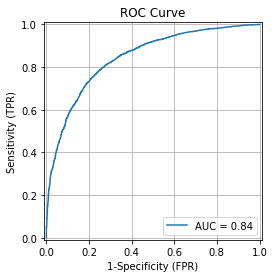

Optimal cutoff is 0.37
Youden's Index (K-S Statistic) is 0.54
Model's AUC is 0.84


In [231]:
# Visualize the ROC curve

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_train, X_train_imp['INS_hat'])

# Compute Youden's Index
data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)
youden = youden.sort_values(by = ['Youden'], ascending = False)
display(youden.head(5))

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc(fpr, tpr))
roc_display.plot()

plt.title('ROC Curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.grid(True)

plt.show()

# Print the optimal cutoff, Youden's index, and AUC
print("Optimal cutoff is", round(youden.loc[1299, 'Cut-off'], 2))
print("Youden's Index (K-S Statistic) is", round(youden.loc[1299, 'Youden'], 2))
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

# The second highest training AUC we have seen thus far, but still will need to test its generalizability on the validation dataset

## Validation Dataset
* Get the predicted probabilities of all observations and compute the AUC

In [229]:
# Predicted probabilities on the training dataset
INS_hat = xgb.predict_proba(X_val_imp)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})

X_val_imp['INS_hat'] = INS_hat

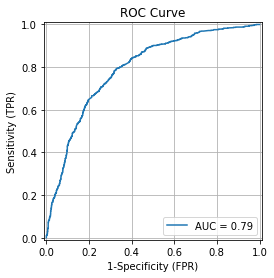

Model's AUC is 0.79


In [230]:
# Visualize the ROC curve

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_val, X_val_imp['INS_hat'])

# Plot ROC curve
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc(fpr, tpr))
roc_display.plot()

plt.title('ROC Curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.grid(True)

plt.show()

# Print the AUC
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

# Performed worse compared to the training dataset according to the AUC
# May be due to slightly overfitting the training data even though we implemented a 10-fold cross validation and variable selection
# Compared to the logistic regression model, the XGBoost model has a higher AUC by 0.01, which is the same AUC as the random forest classifier

In [232]:
# Confusion matrix where we make predictions from predicted probabilities based on the optimal cut-off
X_val_imp['INS_pred'] = X_val_imp['INS_hat'].map(lambda x: 1 if x > (youden.loc[1299, 'Cut-off']) else 0)
pd.crosstab(Y_val, X_val_imp['INS_pred'])

INS_pred,0,1
INS,,
0,994,388
1,204,538


In [234]:
xgb_results_train = X_train_imp[['INS_hat']]
xgb_results_train.to_csv('Train_Results_XGB.csv')

xgb_results_val = X_val_imp[['INS_hat']]
xgb_results_val.to_csv('Val_Results_XGB.csv')